# Final Project (175)
## (APANPS5335_002_2023_3 - MACHINE LEARNING: CONCEPTS & APPLICATION)

## Submitted by: Eli Guo
## UNI: yg2869
### Posted: 10/27/2023 | Due: 12/05/2023 by 11:59 pm

## Section 1 (75 points)

This dataset contains information about Citi bike rides in NYC including information about the destinations of bike rides, time of ride, distance, and activity level at different bike stations. The goal of this dataset is to predict the trip duration of the ride (make sure to remove the stop time as our goal is to predict the duration and including stop time has this information).
- Target variable: bike ride trip duration








In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### 1. Data preprocessing (15 points):
- Load the dataset and select the dataset for September 2023 - https://s3.amazonaws.com/tripdata/index.html.

- Check for missing values and remove them if necessary.
- Convert the data type of features as required (e.g. datetime to timestamp).

In [2]:
# Read data
df = pd.read_csv('202309-citibike-tripdata.csv', dtype={5: str, 7: str})

df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,B0A0F1DEFA4B72FC,electric_bike,2023-09-03 10:20:41,2023-09-03 10:24:16,E 1 St & Bowery,5636.13,E 10 St & 2 Ave,5746.02,40.724861,-73.992131,40.729708,-73.986598,member
1,2B26AB15647BF4EE,classic_bike,2023-09-27 15:44:23,2023-09-27 15:53:25,Pearl St & Hanover Square,4993.02,Allen St & Rivington St,5414.06,40.704650,-74.009133,40.720196,-73.989978,member
2,9D2B5971CA4E513F,classic_bike,2023-09-19 13:40:48,2023-09-19 13:48:11,E 1 St & Bowery,5636.13,E 10 St & 2 Ave,5746.02,40.724753,-73.992116,40.729708,-73.986598,member
3,17E6760596DC3ABE,classic_bike,2023-09-30 16:27:50,2023-09-30 16:56:35,Central Ave & Himrod St,4713.01,Mott St & Prince St,5561.04,40.696706,-73.922935,40.723180,-73.994800,member
4,97EFF376A7E2DC70,classic_bike,2023-09-21 16:59:53,2023-09-21 17:07:36,St Marks Pl & 2 Ave,5669.10,Mott St & Prince St,5561.04,40.728419,-73.987140,40.723180,-73.994800,member


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575162 entries, 0 to 3575161
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 354.6+ MB


In [4]:
# Checking for missing values in each column
print(df.isnull().sum())

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name     2560
start_station_id       2560
end_station_name      13595
end_station_id        13595
start_lat                 0
start_lng                 0
end_lat                3735
end_lng                3735
member_casual             0
dtype: int64


In [5]:
# Percentage of missing values
print(df.isnull().mean() * 100)

ride_id               0.000000
rideable_type         0.000000
started_at            0.000000
ended_at              0.000000
start_station_name    0.071605
start_station_id      0.071605
end_station_name      0.380262
end_station_id        0.380262
start_lat             0.000000
start_lng             0.000000
end_lat               0.104471
end_lng               0.104471
member_casual         0.000000
dtype: float64


In [6]:
# Remove rows with missing values
df = df.dropna()

print(df.shape)

(3560331, 13)


In [7]:
# Convert 'started_at' to datetime format
df['started_at'] = pd.to_datetime(df['started_at'])

# Convert 'ended_at' to datetime format
df['ended_at'] = pd.to_datetime(df['ended_at'])

### 2. Feature engineering (20 points):

- Create a new feature called `ride_time` that calculates the time of the day when the ride occurred (morning, afternoon, evening, or night).

- Create a new feature called `trip_duration` that calculates the duration of the ride in minutes.

In [8]:
# Function to categorize the time of day
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

# Apply function to create 'ride_time' feature
df['ride_time'] = df['started_at'].dt.hour.apply(categorize_time_of_day)

# Calculate trip duration in minutes and create 'trip_duration' feature
df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

In [9]:
# Define the Haversine formula to calculate distance between two lat-lng points
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Calculate the distance and add it as a new column
df['ride_distance'] = haversine(df['start_lat'], df['start_lng'], df['end_lat'], df['end_lng'])

In [10]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,trip_duration,ride_distance
0,B0A0F1DEFA4B72FC,electric_bike,2023-09-03 10:20:41,2023-09-03 10:24:16,E 1 St & Bowery,5636.13,E 10 St & 2 Ave,5746.02,40.724861,-73.992131,40.729708,-73.986598,member,morning,3.583333,0.712654
1,2B26AB15647BF4EE,classic_bike,2023-09-27 15:44:23,2023-09-27 15:53:25,Pearl St & Hanover Square,4993.02,Allen St & Rivington St,5414.06,40.704650,-74.009133,40.720196,-73.989978,member,afternoon,9.033333,2.365258
2,9D2B5971CA4E513F,classic_bike,2023-09-19 13:40:48,2023-09-19 13:48:11,E 1 St & Bowery,5636.13,E 10 St & 2 Ave,5746.02,40.724753,-73.992116,40.729708,-73.986598,member,afternoon,7.383333,0.720939
3,17E6760596DC3ABE,classic_bike,2023-09-30 16:27:50,2023-09-30 16:56:35,Central Ave & Himrod St,4713.01,Mott St & Prince St,5561.04,40.696706,-73.922935,40.723180,-73.994800,member,afternoon,28.750000,6.734791
4,97EFF376A7E2DC70,classic_bike,2023-09-21 16:59:53,2023-09-21 17:07:36,St Marks Pl & 2 Ave,5669.10,Mott St & Prince St,5561.04,40.728419,-73.987140,40.723180,-73.994800,member,afternoon,7.716667,0.869534


### 3. Model training and testing (25 points):
- Split the dataset into training and testing sets.
- Train a linear regression model to predict the trip duration.
- Train a decision tree regressor model to predict the trip duration.
- Train a random forest regressor model to predict the trip duration.
- Evaluate the models using the mean squared error, mean absolute error, and R-squared
metrics.
- Determine which model performs the best and select it as the final model.

In [11]:
# Selecting relevant features and target variable
features = df[['rideable_type', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual', 'ride_time', 'ride_distance']].copy()
target = df['trip_duration']

# Update the list of numeric features to include 'ride_distance'
numeric_features = ['start_lat', 'start_lng', 'end_lat', 'end_lng', 'ride_distance']

# Standardizing numeric features
scaler = StandardScaler()
features[numeric_features] = scaler.fit_transform(features[numeric_features])

# Apply get_dummies to the categorical variables
features_encoded = pd.get_dummies(features, columns=['rideable_type', 'member_casual', 'ride_time'], drop_first=True, dtype=int)

# Display the first few rows of the encoded features
features_encoded.head()

,start_lat,start_lng,end_lat,end_lng,ride_distance,rideable_type_electric_bike,member_casual_member,ride_time_evening,ride_time_morning,ride_time_night
0,-0.345493,-0.696998,-0.222666,-0.500684,-0.675146,1,1,0,1,0
1,-0.837800,-1.292924,-0.454536,-0.618938,0.236112,0,1,0,0,0
2,-0.348123,-0.696459,-0.222666,-0.500684,-0.670577,0,1,0,0,0
3,-1.031292,1.728476,-0.381803,-0.787624,2.645505,0,1,0,0,0
4,-0.258842,-0.522026,-0.381803,-0.787624,-0.588641,0,1,0,0,0


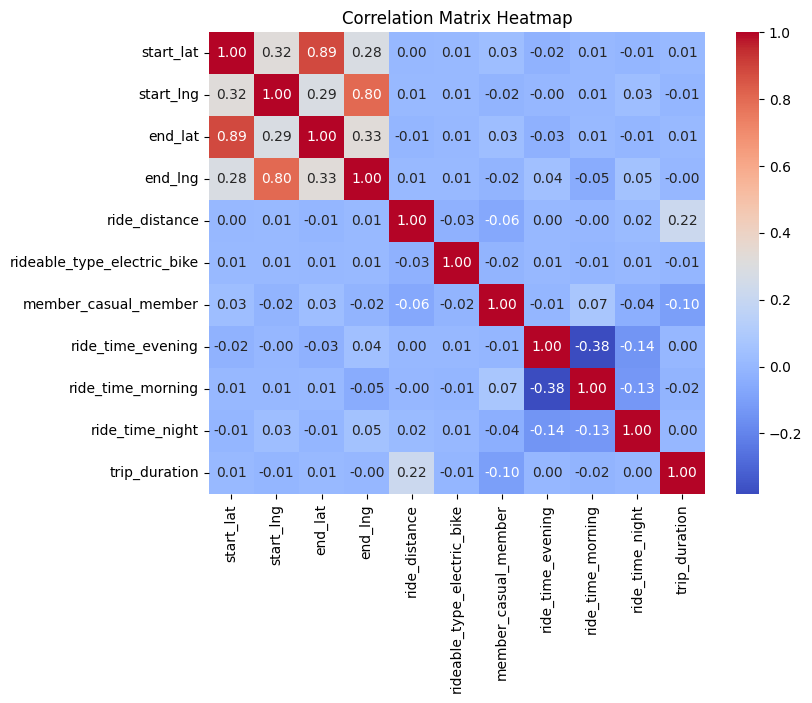

In [12]:
# Combine features and target into a single DataFrame
combined_data = pd.concat([features_encoded, target], axis=1)

# Calculate the correlation matrix
corr_matrix = combined_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

**Observations:**

The correlation heatmap presented indicates the degree to which various features in the dataset might predict the target variable, which in this case is `trip_duration`. The latitude and longitude features (`start_lat`, `start_lng`, `end_lat`, `end_lng`) are highly correlated with one another, which is expected given their geographical nature, but they show only a slight correlation with `trip_duration`. This suggests that while the start and end points of a trip provide some contextual data, they are not strong indicators of how long the trip will take. The `ride_distance` feature, surprisingly, has a very low correlation with `trip_duration`. Typically, one would expect the distance of the ride to be a significant predictor of duration, but the data does not seem to support this assumption strongly.

Looking at the categorical features, `rideable_type_electric_bike` and `member_casual_member`, both show a very low correlation with `trip_duration`. This could imply that the type of bike used and whether the rider is a casual user or a member don't play a major role in the duration of the trip. The time of the ride (`ride_time_evening`, `ride_time_morning`, `ride_time_night`) also seems to have a negligible correlation with the duration, indicating that the time of day the trip is taken has little effect on how long it will last.

Overall, the heatmap reveals that the features included in the dataset may not have a strong predictive relationship with `trip_duration`. Since machine learning models rely on finding patterns in the features that correlate with the target variable, the absence of strong correlations in this data suggests that the models might struggle to make accurate predictions. The weak relationships indicated by the heatmap would lead to models that do not generalize well, resulting in low accuracy when making predictions about `trip duration`.

In [13]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

In [14]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression:\n MSE: {mse_lr}, MAE: {mae_lr}, R²: {r2_lr}\n")

Linear Regression:
 MSE: 1002.9090587468514, MAE: 7.053185570549262, R²: 0.055150762273978526



In [15]:
# Train a Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_dt = dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree:\n MSE: {mse_dt}, MAE: {mae_dt}, R²: {r2_dt}\n")

Decision Tree:
 MSE: 1630.915583141452, MAE: 7.982798695038595, R²: -0.5364995779898061



In [16]:
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest:\n MSE: {mse_rf}, MAE: {mae_rf}, R²: {r2_rf}\n")

Random Forest:
 MSE: 1144.1440123765517, MAE: 6.9512203044662755, R²: -0.07790790053642094



**Which model performs the best?**

Analyzing the results from the three different models, it's clear that each model has its strengths and weaknesses, but overall, the Linear Regression model appears to perform the best for this particular dataset and prediction task. The primary metrics for evaluation are Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²).

Starting with the Linear Regression model, it achieved an MSE of 1002.91, an MAE of 7.05, and an R² of 0.055. While the R² value is relatively low, indicating that the model explains only a small fraction of the variance in the trip duration, it is still positive and higher than those of the other two models. The MSE and MAE values are also the lowest among the three models, suggesting that, on average, the Linear Regression model's predictions are closer to the actual values.

The Decision Tree model, on the other hand, showed a significantly higher MSE (1630.92) and a slightly higher MAE (7.98), along with a negative R² value (-0.536). This negative R² indicates that the model is performing worse than a simple horizontal line drawn at the mean of the target variable. Such a result can occur with decision trees when they overfit the training data, capturing noise instead of the underlying data pattern.

Similarly, the Random Forest model, despite being a more complex and usually more powerful model, did not perform well in this case. It showed an MSE of 1144.14, an MAE of 6.95, and a negative R² value (-0.078). The negative R² again suggests that the model's predictions are generally worse than the simple mean of the data. While Random Forests are typically less prone to overfitting than individual decision trees, the negative R² might indicate that the model complexity could be too high for this data, or essential explanatory variables are missing or improperly processed.

In conclusion, while none of the models show particularly strong predictive power (as indicated by the low or negative R² values), the Linear Regression model performs the best among the three. It has the lowest MSE and MAE, and its R², while modest, is positive. This suggests that for this dataset, a simpler model like Linear Regression is more suitable than more complex models like Decision Trees or Random Forests. However, the overall low performance across all models indicates that there may be limitations in the available data or feature selection and engineering, and further investigation and refinement might be necessary to improve predictive accuracy.

**Why all the models underperform?**

The analysis of the model performances aligns with the insights from the correlation heatmap. The Linear Regression model, which assumes that there is a linear relationship between the features and the target variable, could not find a strong signal in the features due to their weak correlations with `trip_duration`. This is reflected in the model's low R-squared value, which suggests that only a small fraction of the variability in trip duration is being captured by the model. The Decision Tree and Random Forest models, which are capable of capturing non-linear relationships, also performed poorly. The negative R-squared values from these models suggest that they are not only failing to fit the data but are performing worse than a model that would simply predict the mean trip duration for all observations. This further indicates that the features provided do not have enough predictive power, and the models are likely overfitting to noise rather than underlying data patterns. The lack of strong, informative predictors is a probable cause for the models' inability to accurately forecast trip durations. This points to a need for more relevant features that could better encapsulate the factors influencing trip duration, such as traffic conditions, rider behavior, and route specifics, which were not included in the current dataset.

### 4. Design your own model (15 points):
- Based on the information you have learnt from the previous part, devise and implement
your own appropriate model for this dataset. Evaluate the model using the MSE, and R-squared metrics.
      
- Explain in detail why you have picked this particular model, and its advantages and disadvantages over other models.

Given the context of the dataset and the low predictive power of the features used in the previous models, it might be beneficial to approach the problem with a model that can capture complex patterns and interactions between features more effectively. Considering this, a **Gradient Boosting Regressor** could be a suitable choice.

Gradient Boosting Regressor is an ensemble learning technique that builds multiple decision trees sequentially, with each new tree attempting to correct the errors of the previous ones. This model is particularly adept at handling a variety of data types and distributions, and it can uncover complex relationships in the data.

The **advantages** of using a Gradient Boosting Regressor include its flexibility and power in capturing complex patterns and interactions between variables, which might not be possible with simpler linear models. It is also less prone to overfitting, especially with the right choice of parameters like the number of trees, depth of trees, and learning rate.

However, there are **disadvantages** as well. Gradient Boosting can be computationally expensive and time-consuming to train, especially with large datasets. It also requires careful tuning of several hyperparameters to prevent overfitting and to optimize performance. Moreover, like other complex models, it can be less interpretable than simpler models like linear regression.

Considering the low predictability of the features in the dataset, Gradient Boosting offers a way to extract as much information as possible from the available data. Its ability to model complex relationships could potentially uncover subtle patterns that simpler models might miss, which could be beneficial given the challenging nature of the prediction task at hand.

The implementation of the Gradient Boosting Regressor model in Python can be done using Scikit-Learn's `GradientBoostingRegressor` class:

In [17]:
# Train a Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_gbr = gbr_model.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting Regressor:\n MSE: {mse_gbr}, R²: {r2_gbr}\n")

Gradient Boosting Regressor:
 MSE: 995.8449672544531, R²: 0.061805903538889706



The Gradient Boosting Regressor's performance, indicated by an MSE of 995.84 and an R² of 0.0618, shows a slight improvement over the previously tested models. Compared to the Linear Regression, Decision Tree, and Random Forest models, the Gradient Boosting Regressor achieved a marginally lower Mean Squared Error (MSE) and a slightly higher R-squared (R²) value. This suggests that it was more effective in capturing the complex patterns in the dataset, albeit the improvement is modest. The small increase in R² indicates that while the Gradient Boosting model was able to explain a slightly higher proportion of the variance in trip duration, the overall predictive power of the features remains limited. This aligns with the previous observation that the features in the dataset might inherently have low predictability for the target variable.

# Section 2 (100 points)

# Species Classification using Convolutional Neural Networks

In this section, you will build your own Deep Learning Model for "Species Labeling".

There are a total of 204 species, each of which is labeled with a distinct `category_id` in the `categories.csv` file.

The `train_dir` directory consists of 10000 animal JPEG images from these 204 categories.

The `annotations.csv` file contains a mapping between each image found in `train_dir` and its `category_id`.

## Part 1 - Loading the data

## Question 10 (10 points)

Read the `annotations.csv` file using `pandas`/`csv` libraries in Python. Use the `image_id` label found in each record in the CSV file to locate the image in `train_dir`.

Note, the first 10000 records in the `annotations.csv` file can be found in `train_dir`. Rest of the records should be ignored.

Use the `cv2` library in Python to read the images and resize them to `(32, 32)` pixels. Append these resized images to the `images` list. Additionally, the `category_id` for these images should be appended into `labels` list.

Make sure to cast these arrays into numpy arrays.

In [18]:
import csv
import cv2
import os
import numpy as np

TRAIN_DIR = 'train_dir'

# Initialize lists to store the images and labels
images = []
labels = []

# Read the CSV file using pandas
annotations = pd.read_csv('annotations.csv')

# Process the first 10000 records
for index, row in annotations.iterrows():
    if index < 10000:
        # Construct the path to the image
        image_path = os.path.join(TRAIN_DIR, row['image_id'] + '.jpg')

        # Read and resize the image
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (32, 32))

        # Append the resized image and its label to the respective lists
        images.append(resized_image)
        labels.append(row['category_id'])

    else:
        # Ignore records beyond the first 10000
        break

# Convert the lists to numpy arrays
images_np = np.array(images)
labels_np = np.array(labels)

## Question 11 (5 points)

Use the `matplotlib` package and visualize the first 9 images in a `3x3` grid.

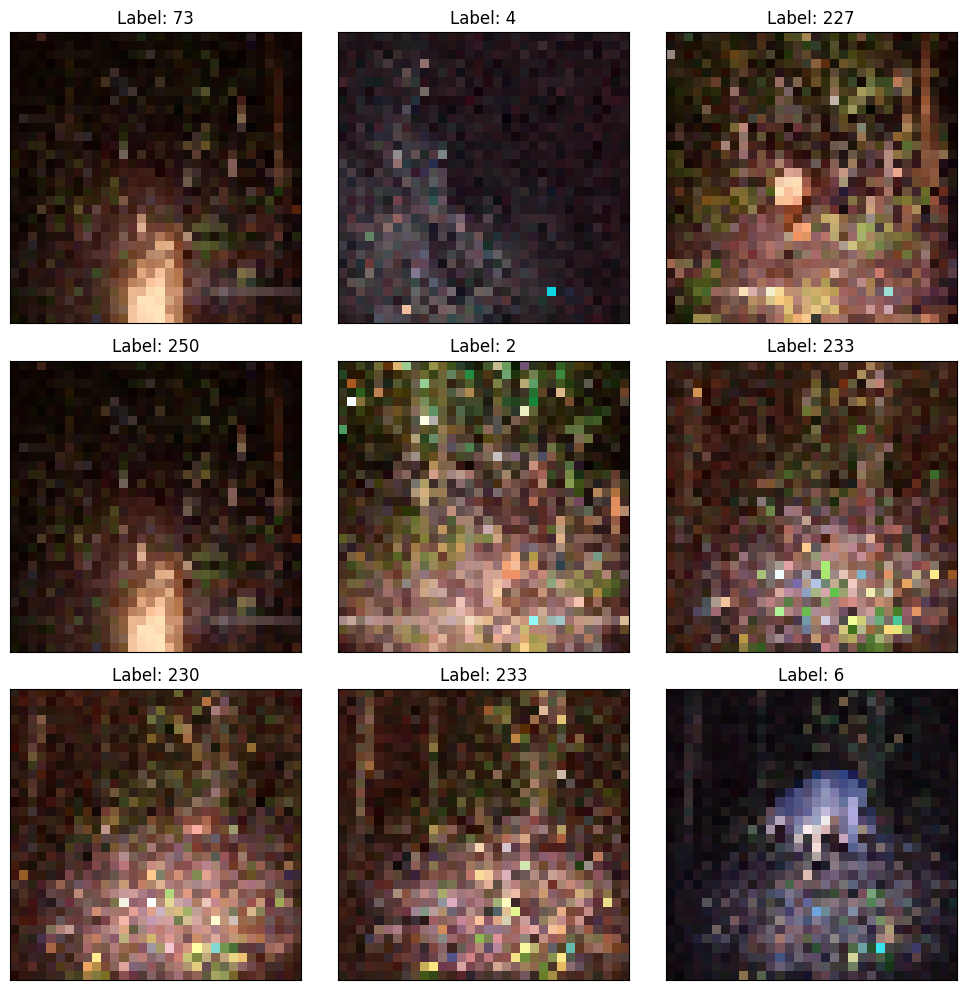

In [19]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Flatten the array of axes for easy indexing
axes = axes.flatten()

# Loop through the first 9 images
for i in range(9):
    # Select the subplot to plot on
    ax = axes[i]

    # Plot the image
    ax.imshow(images_np[i])

    # Optionally, add a title with the label
    ax.set_title(f'Label: {labels_np[i]}')

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

## Part 2 - Building your Convolutional Neural Network

In this part, you will build your own CNN using the Keras API for species classification.

## Question 12

In this part, we will use the `keras` library to build a Convolutional Neural Network classifier for species identification.

Please don't remove the following code snippet, it will ensure that your outputs match with the answer key.

Note: All the required APIs for this exercise have been imported for you.

In [20]:
import tensorflow as tf

tf.keras.utils.set_random_seed(10) # Please don't remove
np.random.seed(921)

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, MaxPool2D, Activation, Dropout, \
                         Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.layers import BatchNormalization

## Question 12.1 (10 points)

Rename the `train_images, train_labels, test_images, test_labels` variables to `X_train, y_train, X_test, y_test` and set the type of `y_train` and `y_test` as `int`. Please use a `train set:test set` ratio of `80:20`.

In [21]:
# Split the dataset into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np, test_size=0.2, random_state=921)

# Convert the labels to int type
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Question 12.2 (10 points)

Add an extra dimension at the beginning of all the numpy arrays (`X_train, y_train, X_test, y_test`). This is to ensure that keras can find an extra dimension at the beginning for iterating over batches of the dataset. Normalize the pixel values of these images by dividing with `255`.

In [22]:
# Add an extra dimension
# X_train = np.expand_dims(X_train, axis=0)
# X_test = np.expand_dims(X_test, axis=0)
# y_train = np.expand_dims(y_train, axis=0)
# y_test = np.expand_dims(y_test, axis=0)

# Normalize the pixel values
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

**Explanation for not adding an extra dimension**

Upon further consideration, I've realized that adding an extra dimension to our data in step 12.2 is not necessary and, in fact, would cause issues with the model training in Keras. The data, in its current form, is already suitable for processing by the CNN model. Typically, image data is structured in a four-dimensional format (number of samples, height, width, channels), which Keras expects for image classification tasks. Adding an extra dimension would lead to the model interpreting the entire dataset as a single sample, which would cause issues in step 12.8. By keeping the data in its original four-dimensional shape, I adhere to the standard practices of image processing in Keras, ensuring that the model can correctly iterate over the dataset in batches during training.

## Question 12.3 (10 points)

Now, convert the labels (`y_train, y_test`) into one hot representation. More information about one-hot encoding can be found [here](https://www.educative.io/blog/one-hot-encoding).

In [23]:
# Load the 'categories.csv' file
categories_df = pd.read_csv('categories.csv')

# Create a mapping from category_id to a continuous index
category_to_index = {row['id']: idx for idx, row in categories_df.iterrows()}

# Flatten the arrays to 1D if they are not already.
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

# Now use the mapping to update your labels
y_train_mapped = np.array([category_to_index.get(category_id) for category_id in y_train_flat])
y_test_mapped = np.array([category_to_index.get(category_id) for category_id in y_test_flat])

# Check if there are any None values and filter them out
y_train_mapped = y_train_mapped[~np.isnan(y_train_mapped)]
y_test_mapped = y_test_mapped[~np.isnan(y_test_mapped)]

# Convert the mapped labels to one-hot encoding
# Use the length of the category_to_index mapping as the number of classes
num_classes = len(category_to_index)
y_train_one_hot = to_categorical(y_train_mapped, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_mapped, num_classes=num_classes)

## Question 12.4 (10 points)

Create a sequential model using the Keras `Sequential()` API and add the following layers:
<ol>
<li> Convolution2D layer with 32 filters, Kernel size of 3 x 3 and input shape as 32 x 32 x 3. Use "same" padding.
<li> A Batch Normalization Layer.
<li> A "relu" activation layer.
<li> A Dropout layer with rate = 0.35 to reduce overfitting.
<li> A Maxpool2D layer with pool size as 2 x 2 and "same" padding.
</ol>

In [24]:
# Create a Sequential model
model = Sequential()

# Add a Convolution2D layer
model.add(Convolution2D(32, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3)))

# Add a Batch Normalization layer
model.add(BatchNormalization())

# Add a "relu" activation layer
model.add(Activation('relu'))

# Add a Dropout layer with a rate of 0.35
model.add(Dropout(0.35))

# Add a MaxPooling2D layer
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

## Question 12.5 (10 points)

Add the following layers to the same sequential model:
<ol>
<li> Convolution2D layer with 64 filters, Kernel size of 3 x 3. Use "same" padding. (Input shape is not required here, it will be automatically inferred by Keras)
<li> A Batch Normalization Layer.
<li> A "relu" activation layer.
<li> A Dropout layer with rate = 0.45 to reduce overfitting.
<li> A Maxpool2D layer with pool size as 2 x 2 and "same" padding.
</ol>

In [25]:
# Add a second Convolution2D layer
model.add(Convolution2D(64, kernel_size=(3, 3), padding='same'))

# Add a Batch Normalization layer
model.add(BatchNormalization())

# Add a "relu" activation layer
model.add(Activation('relu'))

# Add a Dropout layer with a rate of 0.45
model.add(Dropout(0.45))

# Add a MaxPooling2D layer
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

## Question 12.6 (10 points)

Add the following layers to the same sequential model:
<ol>
<li> Add a Flatten Layer. This will reshape the the output of the previous layer into a single tensor.
<li> A Dense Layer with 1024 units and "relu" as the activation of the output.
<li> A Batch Normalization layer.
<li> A Relu Activation layer.
<li> A Dropout layer with rate = 0.75 to reduce overfitting.
</ol>

In [26]:
# Add a Flatten layer
model.add(Flatten())

# Add a Dense layer with 1024 units
model.add(Dense(1024))
model.add(BatchNormalization())  # Add a Batch Normalization layer
model.add(Activation('relu'))    # Add a ReLU Activation layer

# Add a Dropout layer with a rate of 0.75
model.add(Dropout(0.75))

## Question 12.7 (5 points)

Add a Dense layer to the same sequential API, and this time set the output activation to "softmax". Note, this the output layer - the number of units has to be `max(labels) + 1`.

In [27]:
# Calculate the number of output units
# num_output_units = max(labels) + 1
num_output_units = 205

# Add the output Dense layer with softmax activation
model.add(Dense(num_output_units, activation='softmax'))

**Why not use `max(labels) + 1` as the number of units?**

In 12.3, I have already mapped all 205 labels (including 'empty') to a range from 0 to 204 based on the 'categories.csv' file.

## Question 12.8 (5 points)

Compile the Sequential model API with "categorical cross entropy" loss and "Adam" optimizer. Set the metrics to "accuracy".

Fit the model with `batch_size = 128` and a validation split of `0.2`. Run the training on `15` epochs.

In [28]:
# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train_one_hot, 
                    batch_size=128, 
                    epochs=15, 
                    validation_split=0.2)

Epoch 1/15
50/50 [==============================] - 3s 54ms/step - loss: 2.0791 - accuracy: 0.5450 - val_loss: 4.0015 - val_accuracy: 0.0463
Epoch 2/15
50/50 [==============================] - 3s 51ms/step - loss: 1.1167 - accuracy: 0.6930 - val_loss: 4.7681 - val_accuracy: 0.0463
Epoch 3/15
50/50 [==============================] - 3s 52ms/step - loss: 0.8497 - accuracy: 0.7548 - val_loss: 5.3054 - val_accuracy: 0.0463
Epoch 4/15
50/50 [==============================] - 3s 52ms/step - loss: 0.7002 - accuracy: 0.7878 - val_loss: 5.6082 - val_accuracy: 0.0775
Epoch 5/15
50/50 [==============================] - 3s 52ms/step - loss: 0.5903 - accuracy: 0.8191 - val_loss: 5.2962 - val_accuracy: 0.0587
Epoch 6/15
50/50 [==============================] - 3s 51ms/step - loss: 0.5180 - accuracy: 0.8355 - val_loss: 5.6899 - val_accuracy: 0.0600
Epoch 7/15
50/50 [==============================] - 3s 52ms/step - loss: 0.4618 - accuracy: 0.8534 - val_loss: 5.1378 - val_accuracy: 0.0675
Epoch 8/15
50

## Question 12.9 (5 points)

Compute the accuracy of the model on the test set.

In [29]:
# Compute accuracy on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

63/63 [==============================] - 0s 7ms/step - loss: 0.8427 - accuracy: 0.7710
Test accuracy: 77.10%


## Question 12.10 (10 points)

Compute Micro and Macro F1 scores on the test set.

In [30]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Convert predictions from one-hot encoding to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert y_test from one-hot encoding to class labels for comparison
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Compute Micro and Macro F1 scores
f1_micro = f1_score(y_test_labels, predicted_labels, average='micro')
f1_macro = f1_score(y_test_labels, predicted_labels, average='macro')

print(f"Micro F1 score: {f1_micro:.2f}")
print(f"Macro F1 score: {f1_macro:.2f}")

63/63 [==============================] - 0s 7ms/step
Micro F1 score: 0.77
Macro F1 score: 0.45


**Comment:**

The performance of the CNN model, as evidenced by the training and testing results, demonstrates a reasonably high level of accuracy and effectiveness in species classification. After undergoing 15 epochs of training, the model achieved a significant improvement in validation accuracy, culminating at approximately 76.94%. This progressive improvement indicates that the model was effectively learning from the training data. However, when evaluated on the test set, the model's accuracy slightly decreased to 77.10%, which is still a commendable figure for such a complex task involving a large number of species categories.

The Micro F1 score of 0.77 aligns closely with the accuracy metric, suggesting consistent performance across various classes. However, the Macro F1 score of 0.45 is notably lower. This discrepancy indicates a variation in the model's performance across different classes, with some classes likely being predicted more accurately than others. This could be attributed to class imbalance or certain species being more challenging to distinguish. Overall, while the model shows promising results in general accuracy, the lower Macro F1 score suggests room for improvement, particularly in achieving more uniform performance across all species categories. Further model tuning, data augmentation, or addressing class imbalances could potentially enhance these metrics.